In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ardl import ARDL, ardl_select_order, UECM
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model
# import warnings
import fredapi as fa
from datetime import date
from twelvedata import TDClient
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout
import time
import re
import os
os.chdir('/Users/fulinq/Documents/KMITL/FinancialEngineering/Y4/Y4T1/PROJECT/ARDL-ECM/Code')

In [3]:
fred = fa.Fred(api_key='c948956426006ca126a2dd3bd1f07cee')
td = TDClient(apikey='aa61c51218c248698467af34d09b9d46')

## Data Retrieve ##

In [4]:
# 1. Fetch First Batch (Latest 5000 records)
ts1 = td.time_series(
    symbol="XAU/USD",
    interval="1day",
    outputsize=5000,
    timezone="Asia/Bangkok"
)
df1 = ts1.as_pandas()

# Get the oldest date from batch 1 to serve as the end_date for batch 2
oldest_date = df1.index.min()
time.sleep(10) # Wait slightly to respect API rate limits

# 2. Fetch Second Batch (Previous 5000 records)
ts2 = td.time_series(
    symbol="XAU/USD",
    interval="1day",
    outputsize=5000,
    timezone="Asia/Bangkok",
    end_date=oldest_date
)
df2 = ts2.as_pandas()

# 3. Concatenate DataFrames
gold = pd.concat([df1, df2])
all_gold = gold.copy()
all_gold.to_csv('all_gold_data.csv')

# Select only close price
gold = gold[['close']].copy()

# Rename column to 'Gold'
gold.rename(columns={'close': 'Gold'}, inplace=True)

# Convert index to Datetime and remove Timezone (Crucial for merging with FRED)
gold.index = pd.to_datetime(gold.index).tz_localize(None)

# Sort index (Oldest -> Newest)
gold = gold.sort_index()

# Remove duplicate indices (in case of overlap between batches)
gold = gold[~gold.index.duplicated(keep='first')]

# Check and Fill NA
print(f'NaN value before: {gold.isna().sum().sum()}')
gold = gold.ffill()
print(f'NaN value after: {gold.isna().sum().sum()}')

gold

NaN value before: 0
NaN value after: 0


,Gold
datetime,
1987-12-30,482.48001
1987-12-31,485.85001
1988-01-04,480.76001
1988-01-05,480.76001
1988-01-06,483.28000
...,...
2026-01-27,5099.19537
2026-01-28,5327.17903
2026-01-29,5310.53137


In [5]:
dollar_index = fred.get_series('DTWEXBGS') #nominal dollar index
dollar_index.rename('Dollar Index', inplace=True)
dollar_index.index = pd.to_datetime(dollar_index.index) 

# month_ends = pd.date_range(start=dollar_index.index.min(), end=dollar_index.index.max(), freq='M')
# new_index = dollar_index.index.union(month_ends)
# dollar_index = dollar_index.reindex(new_index)

print(f'NaN value : {dollar_index.isna().sum()}')
dollar_index = dollar_index.ffill()
print(f'NaN value after ffill: {dollar_index.isna().sum()}')
dollar_index

NaN value : 207
NaN value after ffill: 0


2006-01-02    101.4155
2006-01-03    100.7558
2006-01-04    100.2288
2006-01-05    100.2992
2006-01-06    100.0241
                ...   
2026-01-19    120.4478
2026-01-20    119.8255
2026-01-21    119.7240
2026-01-22    119.5823
2026-01-23    119.2855
Name: Dollar Index, Length: 5235, dtype: float64

In [6]:
ppi = fred.get_series('PPIACO') #PPI all commodities
ppi.rename('PPI', inplace=True)
ppi.index = pd.to_datetime(ppi.index)
print(f'NaN value : {ppi.isna().sum()}')
ppi = ppi.ffill()
print(f'NaN value after ffill: {ppi.isna().sum()}')
ppi

NaN value : 0
NaN value after ffill: 0


1913-01-01     12.100
1913-02-01     12.000
1913-03-01     12.000
1913-04-01     12.000
1913-05-01     11.900
               ...   
2025-08-01    262.110
2025-09-01    262.094
2025-10-01    260.724
2025-11-01    261.358
2025-12-01    260.686
Name: PPI, Length: 1356, dtype: float64

In [7]:
fed_fund = fred.get_series('FEDFUNDS') #federal fund rate
fed_fund.rename('Federal Fund Rate', inplace=True)
fed_fund.index = pd.to_datetime(fed_fund.index)
fed_fund = fed_fund.mul(0.01)

# month_ends = pd.date_range(start=fed_fund.index.min(), end=fed_fund.index.max(), freq='M')
# new_index = fed_fund.index.union(month_ends)
# fed_fund = fed_fund.reindex(new_index)

print(f'NaN value before processing: {fed_fund.isna().sum()}')
fed_fund = fed_fund.ffill()
fed_fund.rename('Federal Fund Rate', inplace=True) # Re-apply the name after reindexing
print(f'NaN value after processing: {fed_fund.isna().sum()}')
fed_fund

NaN value before processing: 0
NaN value after processing: 0


1954-07-01    0.0080
1954-08-01    0.0122
1954-09-01    0.0107
1954-10-01    0.0085
1954-11-01    0.0083
               ...  
2025-08-01    0.0433
2025-09-01    0.0422
2025-10-01    0.0409
2025-11-01    0.0388
2025-12-01    0.0372
Name: Federal Fund Rate, Length: 858, dtype: float64

In [8]:
vix = fred.get_series('VIXCLS') #CBOE Volatility Index: VIX
vix.rename('VIX', inplace=True)
vix.index = pd.to_datetime(vix.index)
print(f'NaN value : {vix.isna().sum()}')
vix = vix.ffill()
print(f'NaN value after ffill: {vix.isna().sum()}')
vix

NaN value : 301
NaN value after ffill: 0


1990-01-02    17.24
1990-01-03    18.19
1990-01-04    19.22
1990-01-05    20.11
1990-01-08    20.26
              ...  
2026-01-23    16.09
2026-01-26    16.15
2026-01-27    16.35
2026-01-28    16.35
2026-01-29    16.88
Name: VIX, Length: 9413, dtype: float64

In [9]:
unemploy = fred.get_series('ICSA') #Initial Claims
unemploy.rename('ISCA', inplace=True)
unemploy.index = pd.to_datetime(unemploy.index)
print(f'NaN value : {unemploy.isna().sum()}')
unemploy = unemploy.ffill()
print(f'NaN value after ffill: {unemploy.isna().sum()})')
unemploy

NaN value : 0
NaN value after ffill: 0)


1967-01-07    208000.0
1967-01-14    207000.0
1967-01-21    217000.0
1967-01-28    204000.0
1967-02-04    216000.0
                ...   
2025-12-27    200000.0
2026-01-03    207000.0
2026-01-10    199000.0
2026-01-17    210000.0
2026-01-24    209000.0
Name: ISCA, Length: 3082, dtype: float64

In [10]:
ip = fred.get_series('INDPRO') #Industrial Production Index
ip.rename('Industrial Production', inplace=True)
ip.index = pd.to_datetime(ip.index)
print(f'NaN value : {ip.isna().sum()}')
ip = ip.ffill()
print(f'NaN value after ffill: {ip.isna().sum()}')
ip

NaN value : 0
NaN value after ffill: 0


1919-01-01      4.8739
1919-02-01      4.6585
1919-03-01      4.5238
1919-04-01      4.6046
1919-05-01      4.6315
                ...   
2025-08-01    101.5867
2025-09-01    101.7779
2025-10-01    101.5163
2025-11-01    101.9528
2025-12-01    102.3250
Name: Industrial Production, Length: 1284, dtype: float64

In [11]:
fed_balance = fred.get_series('WALCL') #Federal Reserve Total Assets
fed_balance.rename('Fed Balance Sheet', inplace=True)
fed_balance.index = pd.to_datetime(fed_balance.index)
print(f'NaN value : {fed_balance.isna().sum()}')
fed_balance = fed_balance.ffill()
print(f'NaN value after ffill: {fed_balance.isna().sum()}')
fed_balance

NaN value : 0
NaN value after ffill: 0


2002-12-18     719542.0
2002-12-25     732059.0
2003-01-01     730994.0
2003-01-08     723762.0
2003-01-15     720074.0
                ...    
2025-12-31    6640618.0
2026-01-07    6573602.0
2026-01-14    6581700.0
2026-01-21    6584580.0
2026-01-28    6587568.0
Name: Fed Balance Sheet, Length: 1207, dtype: float64

In [12]:
# 1. organize data
realtime_data = {
    'gold': gold,
    'dollar_index': dollar_index,
    'vix': vix,
    'fed_rate': fed_fund,
    'fed_balance': fed_balance,
    'labor_claims': unemploy
}

lagged_data = {
    'ip': ip,
    'ppi': ppi
}

# 2. resample & rename
monthly_dfs = []

# process real-time
for name, data in realtime_data.items():
    # FIX: force rename for both Series and DataFrame to match the key (lowercase)
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0].to_frame(name)
    else:
        data = data.to_frame(name)
    
    if name in ['labor_claims', 'vix']:
        monthly_dfs.append(data.resample('M').mean())
    else:
        monthly_dfs.append(data.resample('M').last())

# process lagged
for name, data in lagged_data.items():
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0].to_frame(name)
    else:
        data = data.to_frame(name)
    monthly_dfs.append(data.resample('M').last())

# 3. merge
df_final = pd.concat(monthly_dfs, axis=1)

# 4. handle lag (shift)
vars_to_shift = ['ip', 'ppi']
for col in vars_to_shift:
    df_final[col] = df_final[col].shift(1)

# 5. target variable
df_final['target_gold'] = df_final['gold'].shift(-1)

# 6. feature selection
features = [
    'gold', 'dollar_index', 'vix', 'fed_rate', 
    'fed_balance', 'labor_claims', 
    'ip', 'ppi'
]

df_model = df_final[features + ['target_gold']].dropna()

# check
print(f"data range: {df_model.index.min().date()} to {df_model.index.max().date()}")
print(df_model.columns)
df_model

data range: 2006-01-31 to 2025-12-31
Index(['gold', 'dollar_index', 'vix', 'fed_rate', 'fed_balance',
       'labor_claims', 'ip', 'ppi', 'target_gold'],
      dtype='object')


,gold,dollar_index,vix,fed_rate,fed_balance,labor_claims,ip,ppi,target_gold
2006-01-31,568.95001,99.4311,12.000909,0.0429,828901.0,295750.0,98.0452,163.000,561.75000
2006-02-28,561.75000,99.7695,12.448000,0.0449,840555.0,290750.0,98.1999,164.300,583.65002
2006-03-31,583.65002,100.5600,11.693913,0.0459,833675.0,301750.0,98.2413,161.800,654.50000
2006-04-30,654.50000,98.1412,11.874000,0.0479,844572.0,303600.0,98.4628,162.200,643.70001
2006-05-31,643.70001,97.7705,14.446087,0.0494,851580.0,332750.0,98.7618,164.300,613.09998
...,...,...,...,...,...,...,...,...,...
2025-08-31,3463.81000,120.6028,15.750000,0.0433,6603384.0,230000.0,101.8940,262.358,3869.18000
2025-09-30,3869.18000,120.5624,15.789091,0.0422,6608395.0,234750.0,101.5867,262.110,3995.65000
2025-10-31,3995.65000,121.7715,18.086522,0.0409,6587034.0,226750.0,101.7779,262.094,4216.34338
2025-11-30,4216.34338,121.4288,19.769500,0.0388,6552419.0,217600.0,101.5163,260.724,4311.26879


In [13]:
df_model.to_csv('gold_price_model_data.csv')

## Data Preparation ##

In [14]:
df_model = pd.read_csv('gold_price_model_data.csv', index_col=0, parse_dates=True)
df_model = df_model[df_model.index >= '2010-01-01']

In [15]:
vars_to_log = ['gold', 'dollar_index', 'vix', 'fed_balance', 'labor_claims', 'ip', 'ppi', 'target_gold']
for col in vars_to_log:
    df_model[f'ln_{col}'] = np.log(df_model[col])

model_vars = ['fed_rate'] + [f'ln_{c}' for c in vars_to_log]
df_ardl = df_model[model_vars].dropna()

df_ardl

,fed_rate,ln_gold,ln_dollar_index,ln_vix,ln_fed_balance,ln_labor_claims,ln_ip,ln_ppi,ln_target_gold
2010-01-31,0.0011,6.986151,4.540779,3.023463,14.625056,13.081125,4.481638,5.182345,7.017954
2010-02-28,0.0013,7.017954,4.539673,3.115713,14.642370,13.093449,4.492478,5.203457,7.015533
2010-03-31,0.0016,7.015533,4.531510,2.877365,14.651524,13.061020,4.496224,5.198497,7.072634
2010-04-30,0.0020,7.072634,4.530902,2.857984,14.661581,13.058358,4.503058,5.211124,7.103495
2010-05-31,0.0020,7.103495,4.567533,3.463740,14.663112,13.037677,4.506444,5.217107,7.124760
...,...,...,...,...,...,...,...,...,...
2025-08-31,0.0433,8.150124,4.792503,2.756840,15.703093,12.345835,4.623933,5.569710,8.260798
2025-09-30,0.0422,8.260798,4.792167,2.759319,15.703851,12.366276,4.620913,5.568764,8.292962
2025-10-31,0.0409,8.292962,4.802146,2.895167,15.700614,12.331603,4.622793,5.568703,8.346724
2025-11-30,0.0388,8.346724,4.799328,2.984140,15.695345,12.290414,4.620219,5.563462,8.368988


In [16]:
def run_adf_test(series, name):
    # Test at Level
    result = adfuller(series.dropna())
    p_value = result[1]
    
    if p_value <= 0.05:
        return f"I(0) - Stationary (p={p_value:.4f})"
    else:
        # ถ้า Level ไม่นิ่ง ให้ลอง Test แบบ Diff (First Difference)
        diff_result = adfuller(series.diff().dropna())
        diff_p_value = diff_result[1]
        
        if diff_p_value <= 0.05:
            return f"I(1) - Stationary at Diff (p={diff_p_value:.4f})"
        else:
            return f"I(2) or Higher (Non-Stationary) (p={diff_p_value:.4f})"

summary_data = []
for col in df_ardl.columns:
    status = run_adf_test(df_ardl[col], col)
    summary_data.append({'Variable': col, 'Status': status})

df_status = pd.DataFrame(summary_data)
df_status

,Variable,Status
0,fed_rate,I(1) - Stationary at Diff (p=0.0499)
1,ln_gold,I(1) - Stationary at Diff (p=0.0000)
2,ln_dollar_index,I(1) - Stationary at Diff (p=0.0003)
3,ln_vix,I(0) - Stationary (p=0.0001)
4,ln_fed_balance,I(1) - Stationary at Diff (p=0.0010)
5,ln_labor_claims,I(0) - Stationary (p=0.0211)
6,ln_ip,I(0) - Stationary (p=0.0099)
7,ln_ppi,I(1) - Stationary at Diff (p=0.0000)
8,ln_target_gold,I(1) - Stationary at Diff (p=0.0000)


In [17]:
X_cols = ['fed_rate', 'ln_gold', 'ln_dollar_index', 'ln_vix', 
          'ln_labor_claims', 'ln_ip', 'ln_ppi'
        # , 'ln_fed_balance'
          ]

X = df_ardl[X_cols].dropna()
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,Variable,VIF
0,const,39018.902641
1,fed_rate,3.713619
2,ln_gold,3.459657
3,ln_dollar_index,2.124159
4,ln_vix,1.763181
5,ln_labor_claims,2.722754
6,ln_ip,2.217031
7,ln_ppi,4.826889


## Model 1 : Fix lag at 1 ##

In [18]:
y_col = 'ln_gold'
X_cols = ['fed_rate', 'ln_dollar_index', 'ln_vix', 
          'ln_labor_claims', 'ln_ip'
        , 'ln_ppi'
          ]

data_ardl = df_ardl[[y_col] + X_cols].dropna()

model_ardl = ARDL(data_ardl[y_col], lags=1, exog=data_ardl[X_cols], order=1)
res_ardl = model_ardl.fit()
res_ardl.summary()

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARDL Model Results                                 
=====================================================================================
Dep. Variable:                       ln_gold   No. Observations:                  192
Model:             ARDL(1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 358.298
Method:                      Conditional MLE   S.D. of innovations              0.037
Date:                       Sat, 31 Jan 2026   AIC                           -686.596
Time:                               14:28:25   BIC                           -637.812
Sample:                           02-28-2010   HQIC                          -666.836
                                - 12-31-2025                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6196      0.655      0.946      0.346      -0.674       1.913
ln_gold.L1             0.9453      0.022     42.209      0.000       0.901       0.990
fed_rate.L0           -8.6706      3.036     -2.856      0.005     -14.663      -2.679
fed_rate.L1            9.1855      2.967      3.096      0.002       3.331      15.040
ln_dollar_index.L0    -1.3304      0.188     -7.091      0.000      -1.701      -0.960
ln_dollar_index.L1     1.3558      0.187      7.269      0.000       0.988       1.724
ln_vix.L0              0.0697      0.019      3.767      0.000       0.033       0.106
ln_vix.L1             -0.0433      0.018     -2.369      0.019      -0.079      -0.007
ln_labor_claims.L0    -0.0401      0.020     -2.022      0.045      -0.079      -0.001
ln_labor_claims.L1     0.0339      0.020      1.695      0.092      -0.006       0.073
ln_ip.L0               0.0600      0.260      0.231      0.818      -0.452       0.572
ln_ip.L1              -0.2378      0.243     -0.979      0.329      -0.717       0.242
ln_ppi.L0              0.0385      0.317      0.121      0.904      -0.588       0.665
ln_ppi.L1              0.0526      0.329      0.160      0.873      -0.596       0.701
======================================================================================
"""

In [19]:
model_uecm = UECM(data_ardl[y_col], lags=1, exog=data_ardl[X_cols], order=1)
res_uecm = model_uecm.fit()
res_uecm.summary()

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  UECM Model Results                                 
=====================================================================================
Dep. Variable:                     D.ln_gold   No. Observations:                  192
Model:             UECM(1, 1, 1, 1, 1, 1, 1)   Log Likelihood                 358.298
Method:                      Conditional MLE   S.D. of innovations              7.372
Date:                       Sat, 31 Jan 2026   AIC                           -686.596
Time:                               14:28:25   BIC                           -637.812
Sample:                           02-28-2010   HQIC                          -666.836
                                - 12-31-2025                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6196      0.655      0.946      0.346      -0.674       1.913
ln_gold.L1              -0.0547      0.022     -2.441      0.016      -0.099      -0.010
fed_rate.L1              0.5149      0.347      1.483      0.140      -0.170       1.200
ln_dollar_index.L1       0.0254      0.038      0.673      0.502      -0.049       0.100
ln_vix.L1                0.0264      0.015      1.765      0.079      -0.003       0.056
ln_labor_claims.L1      -0.0062      0.012     -0.535      0.593      -0.029       0.017
ln_ip.L1                -0.1778      0.146     -1.215      0.226      -0.467       0.111
ln_ppi.L1                0.0911      0.062      1.469      0.144      -0.031       0.214
D.fed_rate.L0           -8.6706      3.036     -2.856      0.005     -14.663      -2.679
D.ln_dollar_index.L0    -1.3304      0.188     -7.091      0.000      -1.701      -0.960
D.ln_vix.L0              0.0697      0.019      3.767      0.000       0.033       0.106
D.ln_labor_claims.L0    -0.0401      0.020     -2.022      0.045      -0.079      -0.001
D.ln_ip.L0               0.0600      0.260      0.231      0.818      -0.452       0.572
D.ln_ppi.L0              0.0385      0.317      0.121      0.904      -0.588       0.665
========================================================================================
"""

In [20]:
ect_coeff = res_uecm.params[f'{y_col}.L1']
ect_pvalue = res_uecm.pvalues[f'{y_col}.L1']
print(f"\nค่า ECT Coefficient: {ect_coeff:.5f}")
print(f"P-value: {ect_pvalue:.5f}")

if ect_coeff < 0 and ect_pvalue < 0.05:
    print("✅ pass: significant and negative ECT (having long-term equilibrium adjustment)")
else:
    print("❌ fail: ECT is positive or not significant (try reducing lag or check variables again)")


ค่า ECT Coefficient: -0.05467
P-value: 0.01563
✅ pass: significant and negative ECT (having long-term equilibrium adjustment)


## Model 2 : AIC Individual Selection ##

In [21]:
y_col = 'ln_gold'
X_cols = ['fed_rate', 'ln_dollar_index', 'ln_vix', 
          'ln_labor_claims', 'ln_ip'
        , 'ln_ppi'
          ]

data_ardl = df_ardl[[y_col] + X_cols].dropna()

custom_max_order = {
    'fed_rate': 6,
    'ln_dollar_index': 5,
    'ln_vix': 3,
    'ln_labor_claims': 6,
    'ln_ip': 4,
    'ln_ppi': 4
}

sel_res = ardl_select_order(
    data_ardl[y_col], 
    maxlag=6, 
    exog=data_ardl[X_cols], 
    maxorder=custom_max_order,
    ic='aic'
)

print(f"Best AR Lags: {sel_res.ar_lags}")
print(f"Best DL Orders: {sel_res.dl_lags}")

/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Best AR Lags: [1, 2, 3, 4]
Best DL Orders: {'fed_rate': [0, 1], 'ln_dollar_index': [0, 1, 2], 'ln_vix': [0, 1], 'ln_labor_claims': [0, 1, 2, 3, 4, 5]}


In [22]:
ar_lag = max(sel_res.ar_lags) if isinstance(sel_res.ar_lags, list) else sel_res.ar_lags
dl_lags = {k: (max(v) if isinstance(v, list) else v) for k, v in sel_res.dl_lags.items()}

print(f"\n--- 2. ARDL Levels Analysis & Bounds Test ---")
model_ardl = ARDL(
    data_ardl[y_col], 
    lags=ar_lag, 
    exog=data_ardl[X_cols], 
    order=dl_lags
)
res_ardl = model_ardl.fit()
res_ardl.summary()


--- 2. ARDL Levels Analysis & Bounds Test ---


/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ip, ln_ppi.
  return _format_order(self.data.orig_exog, order, self._causal)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               ARDL Model Results                              
===============================================================================
Dep. Variable:                 ln_gold   No. Observations:                  192
Model:             ARDL(4, 1, 2, 1, 5)   Log Likelihood                 364.543
Method:                Conditional MLE   S.D. of innovations              0.035
Date:                 Sat, 31 Jan 2026   AIC                           -691.087
Time:                         14:29:14   BIC                           -629.594
Sample:                     06-30-2010   HQIC                          -666.172
                          - 12-31-2025                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2547      0.201      1.269      0.206      -0.142       0.651
ln_gold.L1             0.7402      0.073     10.178      0.000       0.597       0.884
ln_gold.L2             0.1234      0.089      1.390      0.166      -0.052       0.299
ln_gold.L3             0.0058      0.084      0.070      0.945      -0.159       0.171
ln_gold.L4             0.1221      0.064      1.908      0.058      -0.004       0.249
fed_rate.L0           -9.2553      2.571     -3.600      0.000     -14.330      -4.181
fed_rate.L1            9.6884      2.579      3.757      0.000       4.598      14.779
ln_dollar_index.L0    -1.4147      0.179     -7.923      0.000      -1.767      -1.062
ln_dollar_index.L1     0.8329      0.251      3.320      0.001       0.338       1.328
ln_dollar_index.L2     0.5870      0.194      3.032      0.003       0.205       0.969
ln_vix.L0              0.0915      0.018      4.986      0.000       0.055       0.128
ln_vix.L1             -0.0408      0.018     -2.229      0.027      -0.077      -0.005
ln_labor_claims.L0    -0.0602      0.020     -3.045      0.003      -0.099      -0.021
ln_labor_claims.L1     0.0692      0.026      2.635      0.009       0.017       0.121
ln_labor_claims.L2    -0.0347      0.026     -1.333      0.184      -0.086       0.017
ln_labor_claims.L3     0.0230      0.025      0.912      0.363      -0.027       0.073
ln_labor_claims.L4     0.0145      0.024      0.610      0.543      -0.032       0.061
ln_labor_claims.L5    -0.0399      0.015     -2.593      0.010      -0.070      -0.010
======================================================================================
"""

In [23]:
model_uecm = UECM(
    data_ardl[y_col], 
    lags=ar_lag, 
    exog=data_ardl[X_cols], 
    order=dl_lags
)
res_uecm = model_uecm.fit()

ect_coef = res_uecm.params[f'{y_col}.L1']
ect_pval = res_uecm.pvalues[f'{y_col}.L1']

print(f"\n*** FINAL CHECK ***")
print(f"ECT Coefficient: {ect_coef:.5f}")
print(f"P-value:         {ect_pval:.5f}")

if ect_coef < 0 and ect_pval < 0.05:
    print("✅ Model is Valid: Correct adjustment speed")
else:
    print("❌ Model Issue: ECT is positive or insignificant")
    
res_uecm.summary()


*** FINAL CHECK ***
ECT Coefficient: -0.00842
P-value:         0.59068
❌ Model Issue: ECT is positive or insignificant


/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/fulinq/.pyenv/versions/3.12.5/lib/python3.12/site-packages/statsmodels/tsa/ardl/model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: ln_ip, ln_ppi.
  return _format_order(self.data.orig_exog, order, self._causal)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               UECM Model Results                              
===============================================================================
Dep. Variable:               D.ln_gold   No. Observations:                  192
Model:             UECM(4, 1, 2, 1, 5)   Log Likelihood                 364.543
Method:                Conditional MLE   S.D. of innovations              7.359
Date:                 Sat, 31 Jan 2026   AIC                           -691.087
Time:                         14:29:14   BIC                           -629.594
Sample:                     06-30-2010   HQIC                          -666.172
                          - 12-31-2025                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2547      0.201      1.269      0.206      -0.142       0.651
ln_gold.L1              -0.0084      0.016     -0.539      0.591      -0.039       0.022
fed_rate.L1              0.4331      0.299      1.447      0.150      -0.158       1.024
ln_dollar_index.L1       0.0052      0.032      0.163      0.871      -0.058       0.068
ln_vix.L1                0.0507      0.014      3.634      0.000       0.023       0.078
ln_labor_claims.L1      -0.0280      0.011     -2.585      0.011      -0.049      -0.007
D.ln_gold.L1            -0.2514      0.073     -3.452      0.001      -0.395      -0.108
D.ln_gold.L2            -0.1280      0.065     -1.969      0.051      -0.256       0.000
D.ln_gold.L3            -0.1221      0.064     -1.908      0.058      -0.249       0.004
D.fed_rate.L0           -9.2553      2.571     -3.600      0.000     -14.330      -4.181
D.ln_dollar_index.L0    -1.4147      0.179     -7.923      0.000      -1.767      -1.062
D.ln_dollar_index.L1    -0.5870      0.194     -3.032      0.003      -0.969      -0.205
D.ln_vix.L0              0.0915      0.018      4.986      0.000       0.055       0.128
D.ln_labor_claims.L0    -0.0602      0.020     -3.045      0.003      -0.099      -0.021
D.ln_labor_claims.L1     0.0370      0.017      2.167      0.032       0.003       0.071
D.ln_labor_claims.L2     0.0024      0.017      0.141      0.888      -0.031       0.035
D.ln_labor_claims.L3     0.0254      0.015      1.645      0.102      -0.005       0.056
D.ln_labor_claims.L4     0.0399      0.015      2.593      0.010       0.010       0.070
========================================================================================
"""

## OLS Forecasting ##

In [24]:
data_model = pd.read_csv('gold_price_model_data.csv', index_col=0, parse_dates=True)
# data_model = data_model[data_model.index <= '2025-12-01']
data_model

,gold,dollar_index,vix,fed_rate,fed_balance,labor_claims,ip,ppi,target_gold
2006-01-31,568.95001,99.4311,12.000909,0.0429,828901.0,295750.0,98.0452,163.000,561.75000
2006-02-28,561.75000,99.7695,12.448000,0.0449,840555.0,290750.0,98.1999,164.300,583.65002
2006-03-31,583.65002,100.5600,11.693913,0.0459,833675.0,301750.0,98.2413,161.800,654.50000
2006-04-30,654.50000,98.1412,11.874000,0.0479,844572.0,303600.0,98.4628,162.200,643.70001
2006-05-31,643.70001,97.7705,14.446087,0.0494,851580.0,332750.0,98.7618,164.300,613.09998
...,...,...,...,...,...,...,...,...,...
2025-08-31,3463.81000,120.6028,15.750000,0.0433,6603384.0,230000.0,101.8940,262.358,3869.18000
2025-09-30,3869.18000,120.5624,15.789091,0.0422,6608395.0,234750.0,101.5867,262.110,3995.65000
2025-10-31,3995.65000,121.7715,18.086522,0.0409,6587034.0,226750.0,101.7779,262.094,4216.34338
2025-11-30,4216.34338,121.4288,19.769500,0.0388,6552419.0,217600.0,101.5163,260.724,4311.26879


In [25]:
df_ln = pd.DataFrame()
cols_to_transform = ['gold', 'dollar_index', 'vix', 'labor_claims'] # ไม่เอา IP, PPI ตามแผน Core Model
for col in cols_to_transform:
    if col in data_model.columns:
        df_ln[f'ln_{col}'] = np.log(data_model[col])
if 'fed_rate' in data_model.columns:
    df_ln['fed_change'] = data_model['fed_rate']
    
df_ln.dropna(inplace=True)
df_ln

,ln_gold,ln_dollar_index,ln_vix,ln_labor_claims,fed_change
2006-01-31,6.343793,4.599465,2.484982,12.597270,0.0429
2006-02-28,6.331057,4.602863,2.521560,12.580219,0.0449
2006-03-31,6.369302,4.610755,2.459068,12.617354,0.0459
2006-04-30,6.483872,4.586407,2.474351,12.623466,0.0479
2006-05-31,6.467233,4.582623,2.670424,12.715147,0.0494
...,...,...,...,...,...
2025-08-31,8.150124,4.792503,2.756840,12.345835,0.0433
2025-09-30,8.260798,4.792167,2.759319,12.366276,0.0422
2025-10-31,8.292962,4.802146,2.895167,12.331603,0.0409
2025-11-30,8.346724,4.799328,2.984140,12.290414,0.0388


<Figure size 1000x400 with 0 Axes>

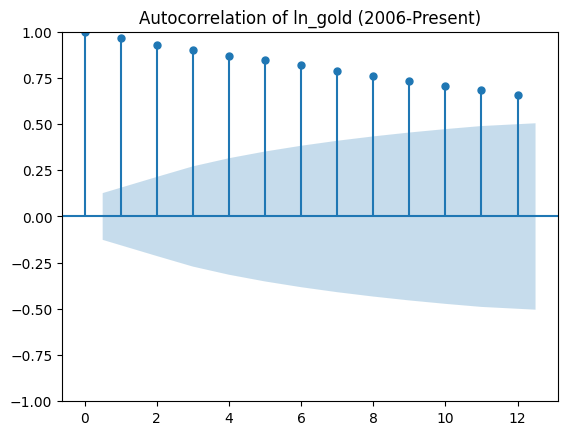

In [26]:
# 2. ACF Analysis
plt.figure(figsize=(10, 4))
plot_acf(df_ln['ln_gold'], lags=12, alpha=0.05)
plt.title('Autocorrelation of ln_gold (2006-Present)')
plt.show()

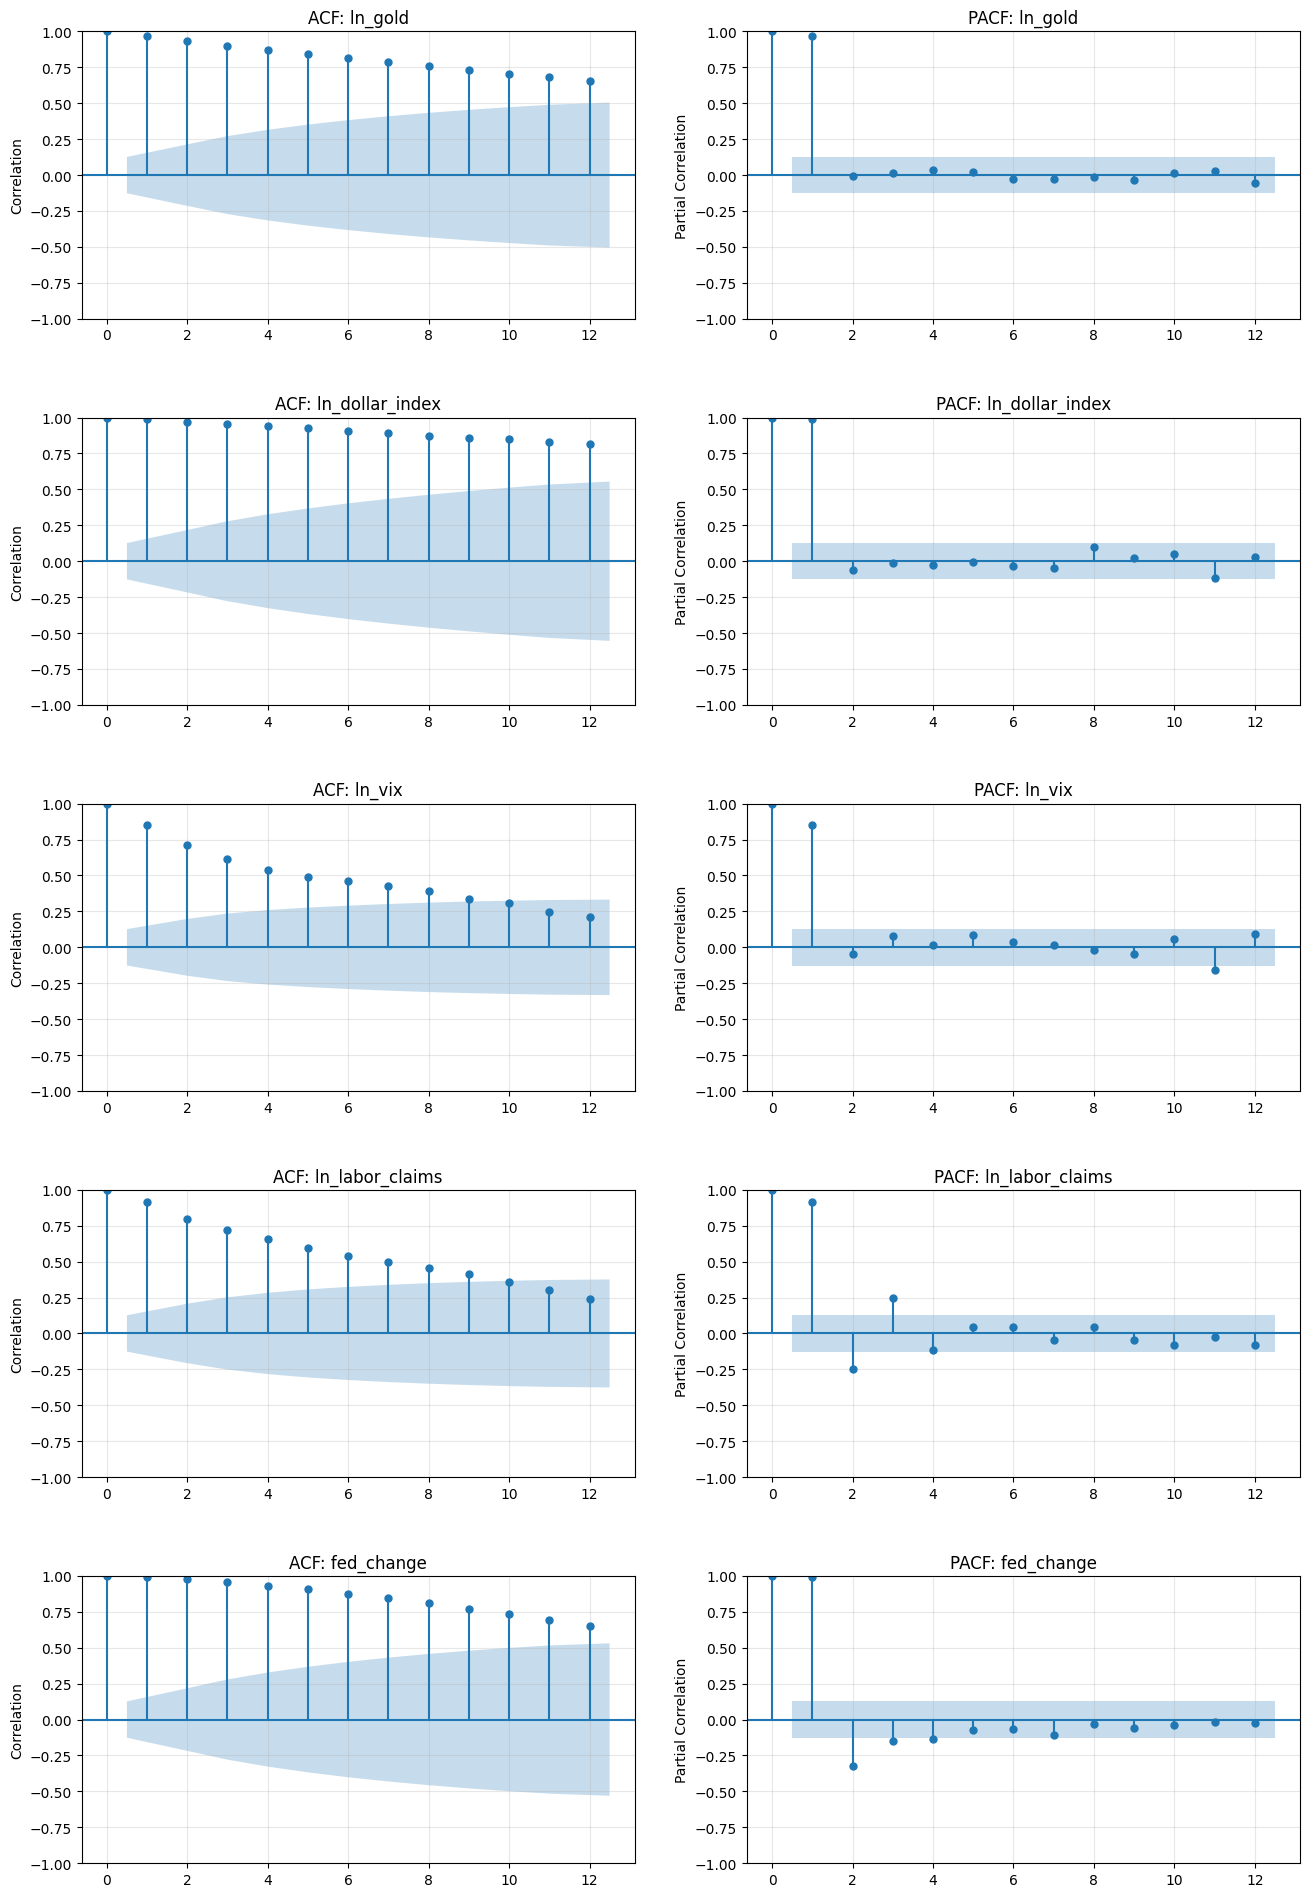

In [27]:
def plot_all_variables_lags(df, lags=12):
    num_cols = df.select_dtypes(include=['number']).columns
    n_vars = len(num_cols)
    
    fig, axes = plt.subplots(nrows=n_vars, ncols=2, figsize=(14, 4 * n_vars))
    
    plt.tight_layout(pad=5.0)
    
    for i, col in enumerate(num_cols):
        plot_acf(df[col].dropna(), lags=lags, ax=axes[i, 0], alpha=0.05)
        axes[i, 0].set_title(f"ACF: {col}")
        axes[i, 0].set_ylabel("Correlation")
        axes[i, 0].grid(True, alpha=0.3)

        plot_pacf(df[col].dropna(), lags=lags, ax=axes[i, 1], alpha=0.05, method='ywm')
        axes[i, 1].set_title(f"PACF: {col}")
        axes[i, 1].set_ylabel("Partial Correlation")
        axes[i, 1].grid(True, alpha=0.3)

    plt.show()
    
plot_all_variables_lags(df_ln, lags=12)

In [38]:
df_lag = df_ln.copy()
feature_cols = df_ln.columns.tolist()

for col in feature_cols:
    df_lag[f'L1_{col}'] = df_lag[col].shift(1)
    df_lag[f'L2_{col}'] = df_lag[col].shift(2)

df_lag.dropna(inplace=True)
df_lag

,ln_gold,ln_dollar_index,ln_vix,ln_labor_claims,fed_change,L1_ln_gold,L2_ln_gold,L1_ln_dollar_index,L2_ln_dollar_index,L1_ln_vix,L2_ln_vix,L1_ln_labor_claims,L2_ln_labor_claims,L1_fed_change,L2_fed_change
2006-03-31,6.369302,4.610755,2.459068,12.617354,0.0459,6.331057,6.343793,4.602863,4.599465,2.521560,2.484982,12.580219,12.597270,0.0449,0.0429
2006-04-30,6.483872,4.586407,2.474351,12.623466,0.0479,6.369302,6.331057,4.610755,4.602863,2.459068,2.521560,12.617354,12.580219,0.0459,0.0449
2006-05-31,6.467233,4.582623,2.670424,12.715147,0.0494,6.483872,6.369302,4.586407,4.610755,2.474351,2.459068,12.623466,12.617354,0.0479,0.0459
2006-06-30,6.418528,4.587498,2.828416,12.629705,0.0499,6.467233,6.483872,4.582623,4.586407,2.670424,2.474351,12.715147,12.623466,0.0494,0.0479
2006-07-31,6.452963,4.584963,2.722454,12.672319,0.0524,6.418528,6.467233,4.587498,4.582623,2.828416,2.670424,12.629705,12.715147,0.0499,0.0494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-31,8.150124,4.792503,2.756840,12.345835,0.0433,8.101499,8.102559,4.804912,4.786048,2.796141,2.912532,12.307049,12.393589,0.0433,0.0433
2025-09-30,8.260798,4.792167,2.759319,12.366276,0.0422,8.150124,8.101499,4.792503,4.804912,2.756840,2.796141,12.345835,12.307049,0.0433,0.0433
2025-10-31,8.292962,4.802146,2.895167,12.331603,0.0409,8.260798,8.150124,4.792167,4.792503,2.759319,2.756840,12.366276,12.345835,0.0422,0.0433
2025-11-30,8.346724,4.799328,2.984140,12.290414,0.0388,8.292962,8.260798,4.802146,4.792167,2.895167,2.759319,12.331603,12.366276,0.0409,0.0422


In [39]:
y = df_lag['ln_gold']
X_candidates = df_lag[[c for c in df_lag.columns if 'L1_' in c]]
X_candidates = sm.add_constant(X_candidates)

# --- Stepwise AIC Selection (หาโมเดลที่ดีที่สุด) ---
best_aic = float('inf')
best_vars = ['const']
candidate_vars = X_candidates.columns.tolist()
candidate_vars.remove('const')

print("\n--- Starting AIC Variable Selection ---")
while True:
    step_best_aic = best_aic
    step_best_var = None
    
    for var in candidate_vars:
        if var in best_vars: continue
        
        temp_vars = best_vars + [var]
        try:
            model = sm.OLS(y, X_candidates[temp_vars]).fit()
            if model.aic < step_best_aic:
                step_best_aic = model.aic
                step_best_var = var
        except:
            continue
            
    if step_best_var:
        best_vars.append(step_best_var)
        best_aic = step_best_aic
        print(f"Added: {step_best_var:<25} | New AIC: {best_aic:.4f}")
    else:
        break

print(f"\n✅ Final Best Variables: {best_vars}")

# --- Fit Final Model ---
final_model = sm.OLS(y, X_candidates[best_vars]).fit()
final_model.summary()


--- Starting AIC Variable Selection ---
Added: L1_ln_gold                | New AIC: -764.5202
Added: L1_fed_change             | New AIC: -767.6969
Added: L1_ln_vix                 | New AIC: -769.8086

✅ Final Best Variables: ['const', 'L1_ln_gold', 'L1_fed_change', 'L1_ln_vix']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ln_gold   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     5209.
Date:                Sat, 31 Jan 2026   Prob (F-statistic):          6.92e-214
Time:                        14:35:18   Log-Likelihood:                 388.90
No. Observations:                 238   AIC:                            -769.8
Df Residuals:                     234   BIC:                            -755.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0359      0.063     -0.573      0.567      -0.159       0.087
L1_ln_gold        0.9977      0.008    124.577      0.000       0.982       1.013
L1_fed_change     0.4333      0.160      2.704      0.007       0.118       0.749
L1_ln_vix         0.0185      0.009      2.019      0.045       0.000       0.037
==============================================================================
Omnibus:                        8.831   Durbin-Watson:                   2.229
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               11.685
Skew:                          -0.273   Prob(JB):                      0.00290
Kurtosis:                       3.938   Cond. No.                         409.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# 5. FORECAST NEXT MONTH

last_row = X_candidates.iloc[[-1]][best_vars]
pred_ln_gold = final_model.predict(last_row).item()

# แปลงกลับเป็นราคา (Price)
last_actual_price = data_model['gold'].iloc[-1]
forecast_price = np.exp(pred_ln_gold)

print("\n" + "="*40)
print("GOLD PRICE FORECAST RESULT")
print("="*40)
print(f"Current Price:      {last_actual_price:,.2f}")
print(f"Forecast Price:     {forecast_price:,.2f}")
print("="*40)


GOLD PRICE FORECAST RESULT
Current Price:      4,311.27
Forecast Price:     4,288.03


In [36]:
# ARCH/GARCH Residual Analysis
X_lag = y.shift(1).dropna()
y_aligned = y.loc[X_lag.index]
X_aligned = sm.add_constant(X_lag)


model_ols_simple = sm.OLS(y_aligned, X_aligned).fit()
residuals = model_ols_simple.resid

lm_test = het_arch(residuals)
print(f"--- Engle's ARCH Test ---")
print(f"LM Statistic: {lm_test[0]:.4f}")
print(f"P-value:      {lm_test[1]:.4f}")

if lm_test[1] < 0.05:
    print("✅ พบความผันผวนแบบกระจุกตัว (Volatility Clustering)")
    print("👉 'ควรใช้ GARCH' มาช่วยจัดการความเสี่ยง")
    
    print("\n--- Running GARCH(1,1) Model ---")
    
    # GARCH Model (ใช้ y เดิมคูณ 100 เพื่อให้ตัวเลขสวยขึ้น/Optimize ง่ายขึ้น)
    # หมายเหตุ: การคูณ 100 เปลี่ยนหน่วยเป็น % Return
    garch_model = arch_model(y_aligned * 100, vol='Garch', p=1, q=1, mean='Constant', dist='Normal')
    res_garch = garch_model.fit(update_freq=5, disp='off')
    
    print(res_garch.summary())
    
    # Plot Volatility
    plt.figure(figsize=(10,4))
    plt.plot(res_garch.conditional_volatility, color='orange', label='GARCH Volatility')
    plt.title('Gold Price Volatility (Risk) over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("❌ no ARCH Effect (constant variance)")
    print("👉 OLS is enough, GARCH has no need")

--- Engle's ARCH Test ---
LM Statistic: 12.9237
P-value:      0.2280
❌ no ARCH Effect (constant variance)
👉 OLS is enough, GARCH has no need


## OLS walking-forward prediction

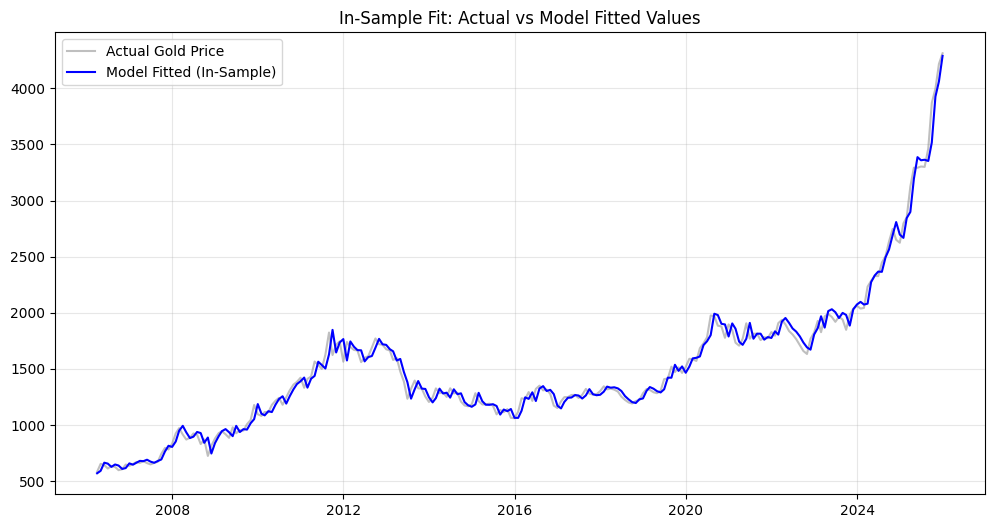

In [41]:
df_results = pd.DataFrame({
    'Actual': y,
    'Fitted': final_model.fittedvalues
}, index=y.index)

plt.figure(figsize=(12, 6))
plt.plot(df_results.index, np.exp(df_results['Actual']), label='Actual Gold Price', color='gray', alpha=0.5)
plt.plot(df_results.index, np.exp(df_results['Fitted']), label='Model Fitted (In-Sample)', color='blue', linewidth=1.5)
plt.title('In-Sample Fit: Actual vs Model Fitted Values')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Start Walk-Forward Validation...
Training on first 166 months, Forecasting last 72 months.


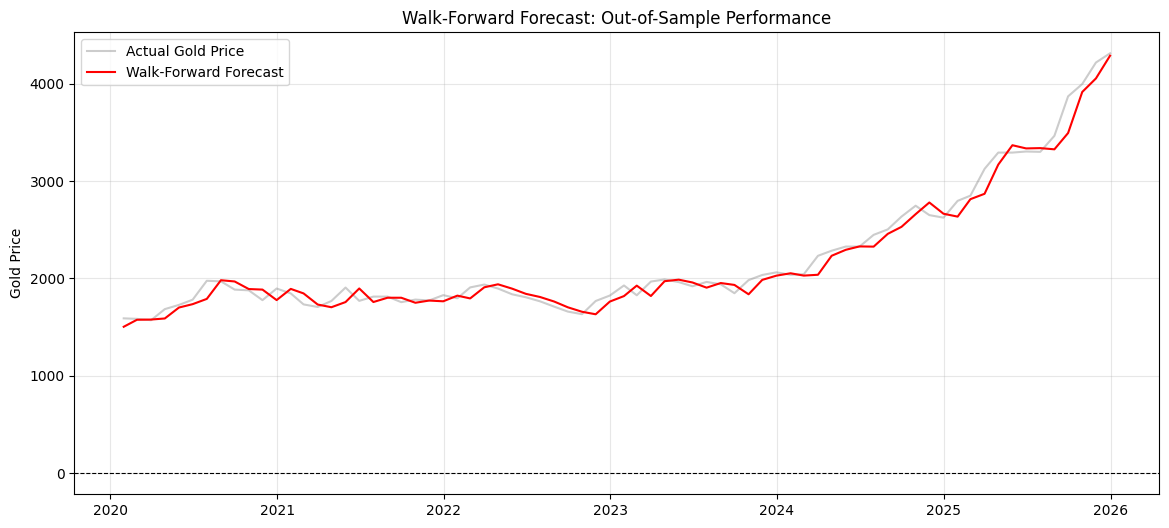

--------------------------------------------------
✅ Forecast Complete!
Range: 2020-01-31 -> 2025-12-31
Total Forecasted Months: 72
RMSE: 0.04268
MAE:  0.03411
--------------------------------------------------


In [44]:
n_total = len(y)
train_ratio = 0.7  # % train
n_train = int(n_total * train_ratio)

predictions = []
actuals = []
dates = []

print(f"Start Walk-Forward Validation...")
print(f"Training on first {n_train} months, Forecasting last {n_total - n_train} months.")

for i in range(n_train, n_total):
    X_train = X_candidates[best_vars].iloc[:i]
    y_train = y.iloc[:i]
    
    X_test_row = X_candidates[best_vars].iloc[[i]]
    y_test_value = y.iloc[i]
    
    model_wf = sm.OLS(y_train, X_train).fit()
    
    pred_value = model_wf.predict(X_test_row).item()
    
    predictions.append(pred_value)
    actuals.append(y_test_value)
    dates.append(y.index[i])
    
df_walk_forward = pd.DataFrame({
    'Actual': actuals,
    'Forecast': predictions
}, index=dates)

fig, ax = plt.subplots(figsize=(14, 6))

# Plot Returns
ax.plot(df_walk_forward.index, np.exp(df_walk_forward['Actual']), label='Actual Gold Price', color='gray', alpha=0.4)
ax.plot(df_walk_forward.index, np.exp(df_walk_forward['Forecast']), label='Walk-Forward Forecast', color='red', linewidth=1.5)

# Highlight Zero Line (แยกโซนกำไร/ขาดทุน)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)

ax.set_title('Walk-Forward Forecast: Out-of-Sample Performance')
ax.set_ylabel('Gold Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

rmse = np.sqrt(mean_squared_error(df_walk_forward['Actual'], df_walk_forward['Forecast']))
mae = mean_absolute_error(df_walk_forward['Actual'], df_walk_forward['Forecast'])
r2 = r2_score(df_walk_forward['Actual'], df_walk_forward['Forecast'])

print("-" * 50)
print(f"✅ Forecast Complete!")
print(f"Range: {df_walk_forward.index.min().date()} -> {df_walk_forward.index.max().date()}")
print(f"Total Forecasted Months: {len(df_walk_forward)}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE:  {mae:.5f}")
# print(f"R² (Out-of-Sample): {r2:.5f}") # อย่าตกใจถ้า R2 ติดลบ (เป็นปกติของ Time Series ระยะยาว)
print("-" * 50)

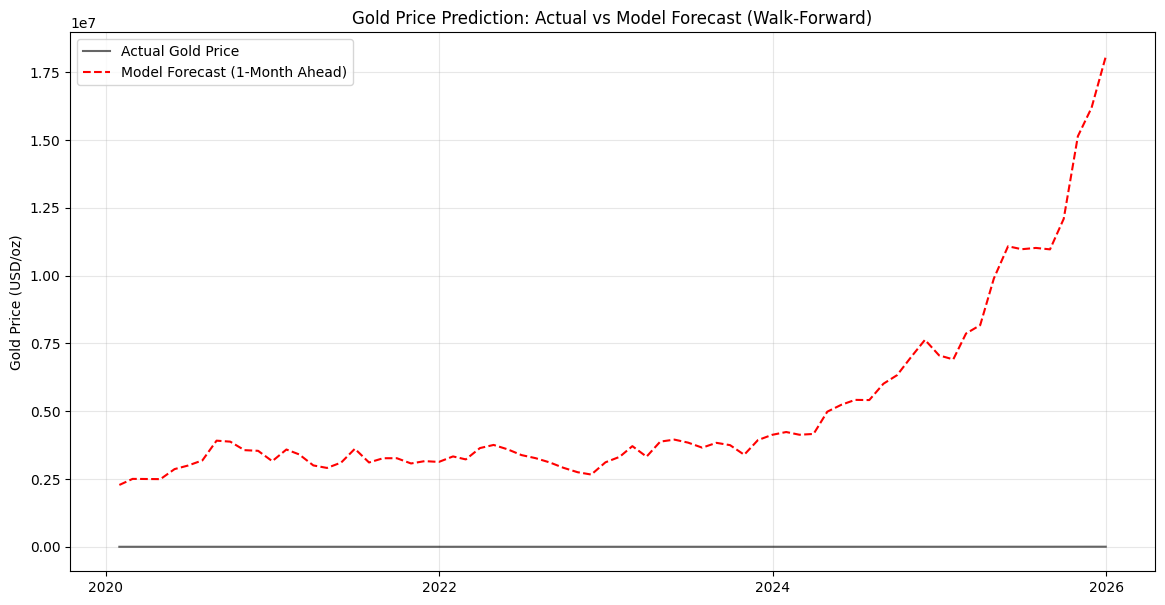

In [45]:
df_price_wf = pd.DataFrame(index=df_walk_forward.index)
df_price_wf['Actual_Price'] = data_model.loc[df_walk_forward.index, 'gold']

df_price_wf['Prev_Actual_Price'] = data_model['gold'].shift(1).loc[df_walk_forward.index]
# Price_t = Price_{t-1} * exp(Return_t)
df_price_wf['Forecast_Return'] = df_walk_forward['Forecast']
df_price_wf['Forecast_Price'] = df_price_wf['Prev_Actual_Price'] * np.exp(df_price_wf['Forecast_Return'])

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df_price_wf.index, df_price_wf['Actual_Price'], 
        label='Actual Gold Price', color='black', alpha=0.6, linewidth=1.5)
ax.plot(df_price_wf.index, df_price_wf['Forecast_Price'], 
        label='Model Forecast (1-Month Ahead)', color='red', linestyle='--', linewidth=1.5)

ax.set_title('Gold Price Prediction: Actual vs Model Forecast (Walk-Forward)')
ax.set_ylabel('Gold Price (USD/oz)')
ax.legend()
ax.grid(True, alpha=0.3)

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.YearLocator(2)) # โชว์ทุก 2 ปี
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

# # --- Error Metrics ---
# mae = np.mean(np.abs(df_price_wf['Forecast_Price'] - df_price_wf['Actual_Price']))
# rmse = np.sqrt(np.mean((df_price_wf['Forecast_Price'] - df_price_wf['Actual_Price'])**2))
# mape = np.mean(np.abs((df_price_wf['Actual_Price'] - df_price_wf['Forecast_Price']) / df_price_wf['Actual_Price'])) * 100

# print(f"--- Model Accuracy on Price Level ---")
# print(f"MAE (Mean Absolute Error):  ${mae:.2f}")
# print(f"RMSE (Root Mean Sq Error):  ${rmse:.2f}")
# print(f"MAPE (Mean Abs % Error):    {mape:.2f}%")

In [ ]:
# Naive Forecast
df_price_wf['Naive_Forecast'] = df_price_wf['Prev_Actual_Price']

# Naive Error
mae_naive = np.mean(np.abs(df_price_wf['Naive_Forecast'] - df_price_wf['Actual_Price']))
rmse_naive = np.sqrt(np.mean((df_price_wf['Naive_Forecast'] - df_price_wf['Actual_Price'])**2))

# OLS Error
mae_model = np.mean(np.abs(df_price_wf['Forecast_Price'] - df_price_wf['Actual_Price']))
rmse_model = np.sqrt(np.mean((df_price_wf['Forecast_Price'] - df_price_wf['Actual_Price'])**2))

print("="*40)
print("   OLS MODEL vs NAIVE BASELINE COMPARISON   ")
print("="*40)
print(f"1. Naive MAE (Error):  ${mae_naive:.2f}")
print(f"2. Model MAE (Error):  ${mae_model:.2f}")
print("-" * 40)

if mae_model < mae_naive:
    improvement = (1 - mae_model / mae_naive) * 100
    print(f"✅ OLS is outperforming Naive by {improvement:.2f}%")
else:
    print(f"❌ OLS is underperforming Naive")

## Expanding Window

In [ ]:
min_obs = 60
expanding_preds = []
expanding_actuals = []
expanding_dates = []

for i in range(min_obs, len(y)):
    X_train = X_candidates[best_vars].iloc[:i]
    y_train = y.iloc[:i]
    
    X_test_row = X_candidates[best_vars].iloc[[i]]
    y_test_value = y.iloc[i]
    
    model_expanding = sm.OLS(y_train, X_train).fit()
    pred_value = model_expanding.predict(X_test_row).item()
    
    expanding_preds.append(pred_value)
    expanding_actuals.append(y_test_value)
    expanding_dates.append(y.index[i])
    
df_expanding = pd.DataFrame({
    'Actual': expanding_actuals,
    'Forecast': expanding_preds
}, index=expanding_dates)

rmse = np.sqrt(mean_squared_error(df_expanding['Actual'], df_expanding['Forecast']))
mae = mean_absolute_error(df_expanding['Actual'], df_expanding['Forecast'])
r2 = r2_score(df_expanding['Actual'], df_expanding['Forecast'])

print("-" * 50)
print(f"✅ Forecast Complete!")
print(f"Range: {df_expanding.index.min().date()} -> {df_expanding.index.max().date()}")
print(f"Total Forecasted Months: {len(df_expanding)}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE:  {mae:.5f}")
# print(f"R² (Out-of-Sample): {r2:.5f}") # อย่าตกใจถ้า R2 ติดลบ (เป็นปกติของ Time Series ระยะยาว)
print("-" * 50)

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df_expanding.index, df_expanding['Actual'], label='Actual Return', color='gray', alpha=0.3)
plt.plot(df_expanding.index, df_expanding['Forecast'], label='Expanding Forecast', color='blue', linewidth=1)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title(f'Expanding Window Forecast (Starting from {df_expanding.index[0].year})')
plt.legend()
plt.show()

In [ ]:
macro_daily_expanding = df_expanding[['Forecast']].copy()
macro_daily_expanding.columns = ['ols_macro_pred']

## Technical Variables Integration ##

In [ ]:
macro_feature = df_expanding[['Forecast']].copy()
macro_feature.columns = ['Macro_Signal']

macro_daily = macro_feature.resample('D').asfreq()
macro_daily = macro_daily.fillna(method='ffill')
macro_daily

In [ ]:
df_daily = pd.read_csv('all_gold_data.csv', index_col=0, parse_dates=True)
df_daily.sort_index(inplace=True)
df_daily = df_daily[~df_daily.index.duplicated(keep='first')]

df_daily.ta.rsi(length=14, append=True) # Momentum
df_daily.ta.macd(fast=12, slow=26, signal=9, append=True) # Trend & Momentum
df_daily.ta.adx(length=14, append=True) # Trend Strength
df_daily.ta.cci(length=20, append=True) # Cyclical Trend
df_daily.ta.bbands(length=20, std=2, append=True) # Volatility
df_daily.ta.atr(length=14, append=True) # Volatility
df_daily.ta.ema(length=50, append=True)
df_daily.ta.ema(length=200, append=True)
df_daily['dist_ema50'] = (df_daily['close'] - df_daily['EMA_50']) / df_daily['EMA_50']
df_daily['dist_ema200'] = (df_daily['close'] - df_daily['EMA_200']) / df_daily['EMA_200']
df_daily['daily_range'] = (df_daily['high'] - df_daily['low']) / df_daily['open']

rolling_mean = df_daily['close'].rolling(window=20).mean()
rolling_std = df_daily['close'].rolling(window=20).std()
df_daily['z_score'] = (df_daily['close'] - rolling_mean) / rolling_std

cols_to_drop = [
    'EMA_50', 'EMA_200',      # เราใช้ dist_ema แทนแล้ว
    'BBU_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0' # เราใช้ bb_width กับ bb_percentage แทนแล้ว
]

cols_to_drop = [c for c in cols_to_drop if c in df_daily.columns]
df_daily.drop(columns=cols_to_drop, inplace=True)
df_daily.dropna(inplace=True)
df_daily

In [ ]:
df_final = macro_daily.join(df_daily, how='inner')
df_final['target_next_return'] = np.log(df_final['close']).diff().shift(-1)
df_final.dropna(inplace=True)

threshold = 0.005
conditions = [
    (df_final['target_next_return'] > threshold),
    (df_final['target_next_return'] < -threshold)
]

choices = [1, -1]
df_final['signal'] = np.select(conditions, choices, default=0)

df_final.to_csv('gold_technical.csv')
df_final

## CNN & LSTM